In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras import layers
from keras import ops
import tensorflow as tf
import pickle

2024-04-19 15:10:03.158509: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-19 15:10:06.094627: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-19 15:10:21.069205: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
num_classes = 22
latent_dim = 10
num_channels = 3
generator_channels = latent_dim + num_classes
discriminator_channels = num_classes + num_channels
batch_size = 128
image_size = 256

In [3]:
def load_data(batch_size=batch_size):
    train_data = keras.utils.image_dataset_from_directory("datasets/padded_training",
                                                            labels="inferred",
                                                            label_mode="categorical",
                                                            image_size=(256,256),
                                                            batch_size=batch_size)
    test_data = keras.utils.image_dataset_from_directory("datasets/padded_testing",
                                                            labels="inferred",
                                                            label_mode="categorical",
                                                            image_size=(256,256),
                                                            batch_size=batch_size)
    return train_data, test_data

In [4]:
train_data, test_data = load_data()

Found 3300 files belonging to 22 classes.


2024-04-19 15:10:43.625902: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 18211 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB MIG 3g.20gb, pci bus id: 0000:e3:00.0, compute capability: 8.0


Found 3298 files belonging to 22 classes.


In [26]:
combined_data = train_data.concatenate(test_data)

In [47]:
def get_generator_block(filters):
    return keras.Sequential([
        layers.Conv2DTranspose(filters, kernel_size=4, strides=2, padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(negative_slope=0.2),
        ]
    )

generator = keras.Sequential([
    keras.Input(shape=(generator_channels,)),
    layers.Normalization(),
    layers.Dense(4*4*generator_channels),
    layers.LeakyReLU(),
    layers.Reshape((4, 4, generator_channels)),
    get_generator_block(512),
    get_generator_block(256),
    get_generator_block(128),
    get_generator_block(64),
    get_generator_block(8),
    get_generator_block(3),
    layers.Conv2D(3, (7,7), padding="same", activation="tanh")
])
generator.summary()

Model: "sequential_65"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_9 (Normalization) │ (None, 32)             │            65 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 512)            │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_55 (LeakyReLU)      │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_5 (Reshape)             │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_59 (Sequential)      │ (None, 8, 8, 512)      │       264,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_60 (Sequential)      │ (None, 16, 16, 256)    │     2,098,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_61 (Sequential)      │ (None, 32, 32, 128)    │       524,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_62 (Sequential)      │ (None, 64, 64, 64)     │       131,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_63 (Sequential)      │ (None, 128, 128, 8)    │         8,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_64 (Sequential)      │ (None, 256, 256, 3)    │           399 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 256, 256, 3)    │           444 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,045,492 (11.62 MB)

 Trainable params: 3,043,485 (11.61 MB)

 Non-trainable params: 2,007 (7.84 KB)

In [48]:
def get_discriminator_block(size):
    return keras.Sequential([
        layers.Conv2D(size, kernel_size=4, strides=2, padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(negative_slope=0.2),
    ])

discriminator = keras.Sequential([
    keras.Input(shape=(image_size, image_size, discriminator_channels)),
    layers.Normalization(),
    get_discriminator_block(3),
    get_discriminator_block(8),
    get_discriminator_block(64),
    get_discriminator_block(128),
    get_discriminator_block(256),
    layers.GlobalAveragePooling2D(),
    layers.Dense(1)
    
])
discriminator.summary()

Model: "sequential_71"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_10                │ (None, 256, 256, 25)   │            51 │
│ (Normalization)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_66 (Sequential)      │ (None, 128, 128, 3)    │         1,215 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_67 (Sequential)      │ (None, 64, 64, 8)      │           424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_68 (Sequential)      │ (None, 32, 32, 64)     │         8,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_69 (Sequential)      │ (None, 16, 16, 128)    │       131,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_70 (Sequential)      │ (None, 8, 8, 256)      │       525,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 667,739 (2.55 MB)

 Trainable params: 666,770 (2.54 MB)

 Non-trainable params: 969 (3.79 KB)

In [49]:
class ConditionalGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.seed_generator = keras.random.SeedGenerator(1337)
        self.gen_loss_tracker = keras.metrics.Mean(name="g_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="d_loss")

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker]

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, data):
        # Unpack the data.
        real_images, one_hot_labels = data

        # Add dummy dimensions to the labels so that they can be concatenated with
        # the images. This is for the discriminator.
        image_one_hot_labels = one_hot_labels[:, :, None, None]
        image_one_hot_labels = ops.repeat(
            image_one_hot_labels, repeats=[image_size * image_size]
        )
        image_one_hot_labels = ops.reshape(
            image_one_hot_labels, (-1, image_size, image_size, num_classes)
        )

        # Sample random points in the latent space and concatenate the labels.
        # This is for the generator.
        batch_size = ops.shape(real_images)[0]
        random_latent_vectors = keras.random.normal(
            shape=(batch_size, self.latent_dim), seed=self.seed_generator
        )
        random_vector_labels = ops.concatenate(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # Decode the noise (guided by labels) to fake images.
        generated_images = self.generator(random_vector_labels)

        # Combine them with real images. Note that we are concatenating the labels
        # with these images here.
        fake_image_and_labels = ops.concatenate(
            [generated_images, image_one_hot_labels], -1
        )
        real_image_and_labels = ops.concatenate([real_images, image_one_hot_labels], -1)
        combined_images = ops.concatenate(
            [fake_image_and_labels, real_image_and_labels], axis=0
        )

        # Assemble labels discriminating real from fake images.
        labels = ops.concatenate(
            [ops.ones((batch_size, 1)), ops.zeros((batch_size, 1))], axis=0
        )

        # Train the discriminator.
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space.
        random_latent_vectors = keras.random.normal(
            shape=(batch_size, self.latent_dim), seed=self.seed_generator
        )
        random_vector_labels = ops.concatenate(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # Assemble labels that say "all real images".
        misleading_labels = ops.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            fake_images = self.generator(random_vector_labels)
            fake_image_and_labels = ops.concatenate(
                [fake_images, image_one_hot_labels], -1
            )
            predictions = self.discriminator(fake_image_and_labels)
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Monitor loss.
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
        }


In [50]:
np.random.seed(4352)
cond_gan = ConditionalGAN(
    discriminator=discriminator, generator=generator, latent_dim=latent_dim
)
initial_learning_rate = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, 
    decay_steps=100,
    decay_rate=0.96,
    staircase=True)
cond_gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    g_optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
)

In [51]:
history = cond_gan.fit(train_data, epochs=60)

Epoch 1/60
26/26 ━━━━━━━━━━━━━━━━━━━━ 18s 345ms/step - d_loss: 0.6439 - g_loss: 0.6618
Epoch 2/60
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 178ms/step - d_loss: 0.4768 - g_loss: 0.6036
Epoch 3/60
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 178ms/step - d_loss: 0.4251 - g_loss: 0.6290
Epoch 4/60
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 179ms/step - d_loss: 0.3866 - g_loss: 0.6774
Epoch 5/60
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 179ms/step - d_loss: 0.4811 - g_loss: 0.5205
Epoch 6/60
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 178ms/step - d_loss: 0.4113 - g_loss: 0.6479
Epoch 7/60
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 178ms/step - d_loss: 0.3193 - g_loss: 0.8272
Epoch 8/60
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 177ms/step - d_loss: 0.2553 - g_loss: 0.9847
Epoch 9/60
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 179ms/step - d_loss: 0.3265 - g_loss: 0.7647
Epoch 10/60
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 178ms/step - d_loss: 0.3795 - g_loss: 0.6499
Epoch 11/60
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 179ms/step - d_loss: 0.3808 - g_loss: 0.6628
Epoch 12/60
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 179ms/ste

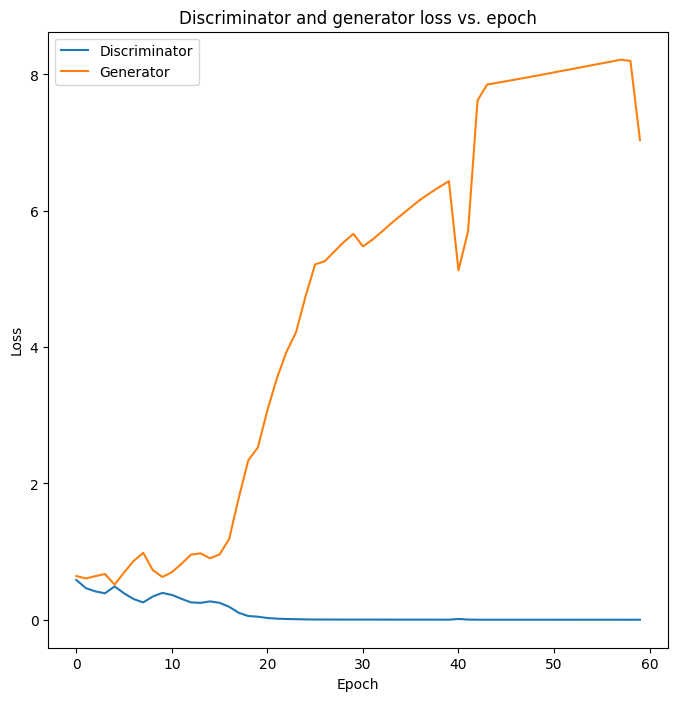

In [52]:
import matplotlib.pyplot as plt    
_, ax = plt.subplots(figsize=(8,8))
ax.plot(history.epoch, history.history['d_loss'], label='Discriminator')
ax.plot(history.epoch, history.history['g_loss'], label='Generator')
ax.set_title('Discriminator and generator loss vs. epoch')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
plt.legend()

In [53]:
noise = keras.random.normal(shape=(1,latent_dim))
noise = ops.repeat(noise, repeats=num_classes)
noise = ops.reshape(noise, (num_classes, latent_dim))

labels = np.arange(num_classes)
labels = keras.utils.to_categorical(labels, num_classes)
noise_and_labels = ops.concatenate([noise, labels], axis=1)

In [54]:
trained_gen = cond_gan.generator
fake = trained_gen.predict(noise_and_labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


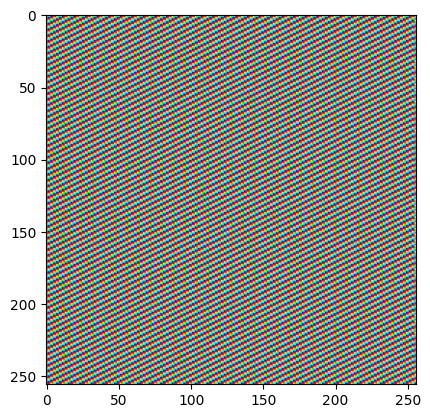

In [55]:
plt.imshow(fake[0])